**Parte uno**: recupero i dati, runno il file di Sho per trovarmi il dataset con tutti i dati

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import geopandas as gpd
import json
from shapely.geometry import Point, shape, Polygon, MultiPolygon, MultiPoint
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import datetime
import pickle
import numpy as np
from shapely.ops import nearest_points
data_path = Path('data')

Sono arrivato a ricavarmi il dataset che mi interessava, ora inizio con l'EDA

In [2]:
infile = open('data/total_datecell0.pkl', 'rb')
total_datecell=pickle.load(infile)
infile.close()
infile = open('data/setgrid_datecell.pkl', 'rb')
setgrid_datecell=pickle.load(infile)
infile.close()

Importo le librerie mancanti prima

In [3]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
files = {'grid':'trentino-grid.geojson',
         'adm_reg':'administrative_regions_Trentino.json',
        'weather':'meteotrentino-weather-station-data.json',
        'precip':'precipitation-trentino.csv',
        'precip-avail':'precipitation-trentino-data-availability.csv',
        'SET-1':'SET-nov-2013.csv',
        'SET-2':'SET-dec-2013.csv',
        'SET-lines':'line.csv',
        'twitter':'social-pulse-trentino.geojson'}

def load_data(path):
    set1 = pd.read_csv(path / files['SET-1'], names = ['LINESET', 'TIMESTAMP', 'POWER'])
    set2 = pd.read_csv(path / files['SET-2'], names = ['LINESET', 'TIMESTAMP', 'POWER'])
    lines = pd.read_csv(path / files['SET-lines'])
    precip = pd.read_csv(path / files['precip'], names = ['TIMESTAMP','CELL_ID', 'INTENSITA'])
    precip_avail = pd.read_csv(path / files['precip-avail'], names = ['TIMESTAMP', 'AFFIDABILE'])
    with open(path / files['weather']) as f:
        meteo_json = json.load(f)
    meteo = gpd.GeoDataFrame(meteo_json['features'])
    meteo['geometry'] = meteo['geomPoint.geom'].apply(lambda x: Point(x['coordinates'][0], x['coordinates'][1]))
    meteo.drop(columns=['geomPoint.geom'], inplace=True)
    grid = gpd.read_file(path / files['grid'])
    with open(path / files['twitter']) as f:
        tweets_json = json.load(f)
    tweets = gpd.GeoDataFrame(tweets_json['features'])
    tweets['geometry'] = tweets['geomPoint.geom'].apply(lambda x: Point(x['coordinates'][0], x['coordinates'][1]))
    tweets.drop(columns=['geomPoint.geom'], inplace=True)
    with open(path / files['adm_reg']) as f:
        regions_json = json.load(f)
    regions = gpd.GeoDataFrame(regions_json['items'])
    localunits = pd.read_csv(path / 'localunits.csv')
    localunitworkers = pd.read_csv(path / 'localunitworkers.csv')
    return set1, set2, lines, precip, precip_avail, meteo, grid, tweets, regions, localunits, localunitworkers

set1, set2, lines, precip, precip_avail, meteo, grid, tweets, regions, lu, luw = load_data(data_path)
set_tot = pd.concat([set1, set2], ignore_index=True)

***EDA***

*Cerco territorio urbano di Trento*

In [5]:
with open('data/tn_adm.json') as f:
    adm_json = json.load(f)
    
for d in adm_json['features']:
    d['geometry'] = shape(d['geometry'])

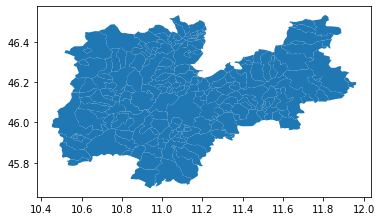

In [6]:
adm_gdf = gpd.GeoDataFrame(adm_json['features'])
adm_gdf.plot()

Seleziono le cellId identificate come comune di Trento

In [7]:
trento = adm_gdf.loc[adm_gdf['properties'].apply(lambda row: row['name'] == 'Trento') == True]

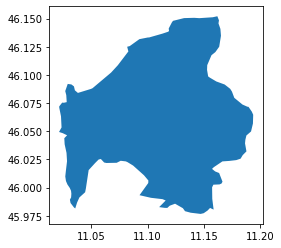

In [8]:
trento['geometry'].plot()

In [9]:
confini_trento = trento['geometry'].loc[142]

Mi recupero le coordinate di tutte le "celle" con i requisiti richiesti sopra

In [10]:
celle_giuste = grid.loc[(grid['geometry'].apply(lambda poligono: poligono.within(confini_trento) == True))]

In [11]:
celle_giuste

cellId                                           geometry
1620    4149  POLYGON ((11.13194 45.99318, 11.14484 45.99294...
1706    4264  POLYGON ((11.10647 46.00266, 11.11938 46.00242...
1707    4265  POLYGON ((11.11938 46.00242, 11.13228 46.00218...
1708    4266  POLYGON ((11.13228 46.00218, 11.14519 46.00194...
1789    4375  POLYGON ((11.02936 46.01305, 11.04227 46.01282...
...      ...                                                ...
3102    6020  POLYGON ((11.12455 46.13733, 11.13749 46.13709...
3103    6021  POLYGON ((11.13749 46.13709, 11.15043 46.13685...
3104    6022  POLYGON ((11.15043 46.13685, 11.16336 46.13660...
3207    6137  POLYGON ((11.12490 46.14632, 11.13784 46.14608...
3208    6138  POLYGON ((11.13784 46.14608, 11.15078 46.14584...

[119 rows x 2 columns]

*Recupero i dati dei consumi elettrici del trentino*

In [13]:
setgrid_datecell

SQUAREID       date  norm_early_cons  norm_late_cons  cellId  \
0            155 2013-11-01        14.585304       26.075768     155   
1            155 2013-11-02        26.031270       26.609743     155   
2            155 2013-11-03        20.691523       23.942211     155   
3            155 2013-11-04        36.039039       28.628543     155   
4            155 2013-11-05        21.844423       25.078079     155   
...          ...        ...              ...             ...     ...   
121019     11099 2013-12-27        11.274654       10.541244   11099   
121020     11099 2013-12-28        12.006342       11.314100   11099   
121021     11099 2013-12-29        12.517356       11.514314   11099   
121022     11099 2013-12-30        12.285582       11.912005   11099   
121023     11099 2013-12-31        12.403064        3.895559   11099   

                                           geometry  
0       POINT (10.92119335145374 45.68639714371787)  
1       POINT (10.92119335145374 45.68639714371787)  
2       POINT (10.92119335145374 45.68639714371787)  
3       POINT (10.92119335145374 45.68639714371787)  
4       POINT (10.92119335145374 45.68639714371787)  
...                                             ...  
121019  POINT (11.77104627753834 46.50599036259381)  
121020  POINT (11.77104627753834 46.50599036259381)  
121021  POINT (11.77104627753834 46.50599036259381)  
121022  POINT (11.77104627753834 46.50599036259381)  
121023  POINT (11.77104627753834 46.50599036259381)  

[121024 rows x 6 columns]

Divido il dataset in dati di giorno e di sera

In [16]:
cons_mattina = setgrid_datecell.drop(columns = 'norm_late_cons')
cons_sera = setgrid_datecell.drop(columns = 'norm_early_cons')

cons_mattina

SQUAREID       date  norm_early_cons  cellId  \
0            155 2013-11-01        14.585304     155   
1            155 2013-11-02        26.031270     155   
2            155 2013-11-03        20.691523     155   
3            155 2013-11-04        36.039039     155   
4            155 2013-11-05        21.844423     155   
...          ...        ...              ...     ...   
121019     11099 2013-12-27        11.274654   11099   
121020     11099 2013-12-28        12.006342   11099   
121021     11099 2013-12-29        12.517356   11099   
121022     11099 2013-12-30        12.285582   11099   
121023     11099 2013-12-31        12.403064   11099   

                                           geometry  
0       POINT (10.92119335145374 45.68639714371787)  
1       POINT (10.92119335145374 45.68639714371787)  
2       POINT (10.92119335145374 45.68639714371787)  
3       POINT (10.92119335145374 45.68639714371787)  
4       POINT (10.92119335145374 45.68639714371787)  
...                                             ...  
121019  POINT (11.77104627753834 46.50599036259381)  
121020  POINT (11.77104627753834 46.50599036259381)  
121021  POINT (11.77104627753834 46.50599036259381)  
121022  POINT (11.77104627753834 46.50599036259381)  
121023  POINT (11.77104627753834 46.50599036259381)  

[121024 rows x 5 columns]

Bene, ora voglio avere un secondo discriminatore oltre al cellId, questo sarà dato dal giorno (mese-giorno visto che l'anno è uguale per tutti).
Per i dataset *total_datecell*,*cons_mattina* e *cons_sera* è stata fatta un'altra manipolazione per riuscire ad usarlo come stringa

In [22]:
def ottieniGiorno(timestamp):
    day = timestamp[5:10]
    
    return day


In [23]:
def ottieniData(date):
    data = str(date)
    day = data[5:10]
    
    return data

In [24]:
total_datecell['TIMESTAMP'] = total_datecell['date'].apply(ottieniData)
cons_mattina['TIMESTAMP'] = cons_mattina['date'].apply(ottieniData)
cons_sera['TIMESTAMP'] = cons_sera['date'].apply(ottieniData)

In [25]:
total_datecell['day'] = total_datecell['TIMESTAMP'].apply(ottieniGiorno)
cons_mattina['day'] = cons_mattina['TIMESTAMP'].apply(ottieniGiorno)
cons_sera['day'] = cons_sera['TIMESTAMP'].apply(ottieniGiorno)

In [26]:
total_datecell = total_datecell.drop(columns = ['TIMESTAMP', 'date'], axis = 1)
cons_mattina = cons_mattina.drop(columns = ['TIMESTAMP', 'date'], axis = 1)
cons_sera = cons_sera.drop(columns = ['TIMESTAMP', 'date'], axis = 1)

In [27]:
total_datecell

cellId  tweetcount  mean_prec  mean_wind  mean_temp    day
0          984         1.0   0.000000        NaN      11.95  11-06
1          984         2.0   0.047917        NaN       6.40  12-22
2         1227         1.0   0.000000        NaN       3.05  11-30
3         1227         1.0   0.000000        NaN       3.10  12-08
4         1341         1.0   0.002083        NaN       6.90  11-25
...        ...         ...        ...        ...        ...    ...
400941   11454         NaN   0.193750       1.10      -0.70  12-27
400942   11454         NaN   0.002105       0.90      -0.65  12-28
400943   11454         NaN   0.016842       1.30      -0.20  12-29
400944   11454         NaN   0.000000       1.45      -4.55  12-30
400945   11454         NaN   0.000000       1.30      -6.15  12-31

[400946 rows x 6 columns]

In [28]:
cons_mattina

SQUAREID  norm_early_cons  cellId  \
0            155        14.585304     155   
1            155        26.031270     155   
2            155        20.691523     155   
3            155        36.039039     155   
4            155        21.844423     155   
...          ...              ...     ...   
121019     11099        11.274654   11099   
121020     11099        12.006342   11099   
121021     11099        12.517356   11099   
121022     11099        12.285582   11099   
121023     11099        12.403064   11099   

                                           geometry    day  
0       POINT (10.92119335145374 45.68639714371787)  11-01  
1       POINT (10.92119335145374 45.68639714371787)  11-02  
2       POINT (10.92119335145374 45.68639714371787)  11-03  
3       POINT (10.92119335145374 45.68639714371787)  11-04  
4       POINT (10.92119335145374 45.68639714371787)  11-05  
...                                             ...    ...  
121019  POINT (11.77104627753834 46.50599036259381)  12-27  
121020  POINT (11.77104627753834 46.50599036259381)  12-28  
121021  POINT (11.77104627753834 46.50599036259381)  12-29  
121022  POINT (11.77104627753834 46.50599036259381)  12-30  
121023  POINT (11.77104627753834 46.50599036259381)  12-31  

[121024 rows x 5 columns]

Con il seguente merge vado a selezionare tra le righe della tabella sopra quelle che hanno un cellId uguale a quello di una delle celle che descrivono il comune di trento

In [32]:
cm10 = pd.merge(left = cons_mattina, right = celle_giuste, how = 'inner', left_on = 'SQUAREID', right_on = 'cellId')
cs10 = pd.merge(left = cons_sera, right = celle_giuste, how = 'inner', left_on = 'SQUAREID', right_on = 'cellId')


cm10

SQUAREID  norm_early_cons  cellId_x  \
0         4264        92.659960      4264   
1         4264        94.482938      4264   
2         4264        88.199350      4264   
3         4264       136.383514      4264   
4         4264       124.025684      4264   
...        ...              ...       ...   
6339      6138        24.578546      6138   
6340      6138        25.706265      6138   
6341      6138        26.844300      6138   
6342      6138        23.123060      6138   
6343      6138        25.211897      6138   

                                       geometry_x    day  cellId_y  \
0     POINT (11.11275447151144 45.99804077050286)  11-01      4264   
1     POINT (11.11275447151144 45.99804077050286)  11-02      4264   
2     POINT (11.11275447151144 45.99804077050286)  11-03      4264   
3     POINT (11.11275447151144 45.99804077050286)  11-04      4264   
4     POINT (11.11275447151144 45.99804077050286)  11-05      4264   
...                                           ...    ...       ...   
6339  POINT (11.14413201154056 46.14146354401746)  12-27      6138   
6340  POINT (11.14413201154056 46.14146354401746)  12-28      6138   
6341  POINT (11.14413201154056 46.14146354401746)  12-29      6138   
6342  POINT (11.14413201154056 46.14146354401746)  12-30      6138   
6343  POINT (11.14413201154056 46.14146354401746)  12-31      6138   

                                             geometry_y  
0     POLYGON ((11.10647 46.00266, 11.11938 46.00242...  
1     POLYGON ((11.10647 46.00266, 11.11938 46.00242...  
2     POLYGON ((11.10647 46.00266, 11.11938 46.00242...  
3     POLYGON ((11.10647 46.00266, 11.11938 46.00242...  
4     POLYGON ((11.10647 46.00266, 11.11938 46.00242...  
...                                                 ...  
6339  POLYGON ((11.13784 46.14608, 11.15078 46.14584...  
6340  POLYGON ((11.13784 46.14608, 11.15078 46.14584...  
6341  POLYGON ((11.13784 46.14608, 11.15078 46.14584...  
6342  POLYGON ((11.13784 46.14608, 11.15078 46.14584...  
6343  POLYGON ((11.13784 46.14608, 11.15078 46.14584...  

[6344 rows x 7 columns]

In [33]:
cm10 = cm10.drop(columns = ['cellId_y','geometry_y'])
cs10 = cs10.drop(columns = ['cellId_y','geometry_y'])

Con questo secondo merge vado ad inserire anche i dati rigurdanti il meteo e twitter

In [34]:
cm11 = pd.merge(left = cm10, right = total_datecell, how = 'inner', left_on = 'SQUAREID', right_on = 'cellId')
cs11 = pd.merge(left = cs10, right = total_datecell, how = 'inner', left_on = 'SQUAREID', right_on = 'cellId')

cm11

SQUAREID  norm_early_cons  cellId_x  \
0           4264        92.659960      4264   
1           4264        92.659960      4264   
2           4264        92.659960      4264   
3           4264        92.659960      4264   
4           4264        92.659960      4264   
...          ...              ...       ...   
386857      6138        25.211897      6138   
386858      6138        25.211897      6138   
386859      6138        25.211897      6138   
386860      6138        25.211897      6138   
386861      6138        25.211897      6138   

                                         geometry_x  day_x  cellId  \
0       POINT (11.11275447151144 45.99804077050286)  11-01    4264   
1       POINT (11.11275447151144 45.99804077050286)  11-01    4264   
2       POINT (11.11275447151144 45.99804077050286)  11-01    4264   
3       POINT (11.11275447151144 45.99804077050286)  11-01    4264   
4       POINT (11.11275447151144 45.99804077050286)  11-01    4264   
...                                             ...    ...     ...   
386857  POINT (11.14413201154056 46.14146354401746)  12-31    6138   
386858  POINT (11.14413201154056 46.14146354401746)  12-31    6138   
386859  POINT (11.14413201154056 46.14146354401746)  12-31    6138   
386860  POINT (11.14413201154056 46.14146354401746)  12-31    6138   
386861  POINT (11.14413201154056 46.14146354401746)  12-31    6138   

        tweetcount  mean_prec  mean_wind  mean_temp  day_y  
0              1.0   0.000000       1.45      14.20  11-01  
1              NaN   0.012500       2.00      13.30  11-02  
2              NaN   0.112500       3.50      14.90  11-03  
3              NaN   0.087500       1.60       9.65  11-04  
4              NaN   0.000000       1.70      11.50  11-05  
...            ...        ...        ...        ...    ...  
386857         NaN   0.000000        NaN       4.60  12-27  
386858         NaN   0.016667        NaN       2.65  12-28  
386859         NaN   0.081250        NaN       5.10  12-29  
386860         NaN   0.000000        NaN       3.40  12-30  
386861         NaN   0.000000        NaN       1.05  12-31  

[386862 rows x 11 columns]

In [35]:
cm3 = cm11.loc[cm11['day_x'] == cm11['day_y']]
cs3 = cs11.loc[cm11['day_x'] == cm11['day_y']]

cm3

SQUAREID  norm_early_cons  cellId_x  \
0           4264        92.659960      4264   
62          4264        94.482938      4264   
124         4264        88.199350      4264   
186         4264       136.383514      4264   
248         4264       124.025684      4264   
...          ...              ...       ...   
386617      6138        24.578546      6138   
386678      6138        25.706265      6138   
386739      6138        26.844300      6138   
386800      6138        23.123060      6138   
386861      6138        25.211897      6138   

                                         geometry_x  day_x  cellId  \
0       POINT (11.11275447151144 45.99804077050286)  11-01    4264   
62      POINT (11.11275447151144 45.99804077050286)  11-02    4264   
124     POINT (11.11275447151144 45.99804077050286)  11-03    4264   
186     POINT (11.11275447151144 45.99804077050286)  11-04    4264   
248     POINT (11.11275447151144 45.99804077050286)  11-05    4264   
...                                             ...    ...     ...   
386617  POINT (11.14413201154056 46.14146354401746)  12-27    6138   
386678  POINT (11.14413201154056 46.14146354401746)  12-28    6138   
386739  POINT (11.14413201154056 46.14146354401746)  12-29    6138   
386800  POINT (11.14413201154056 46.14146354401746)  12-30    6138   
386861  POINT (11.14413201154056 46.14146354401746)  12-31    6138   

        tweetcount  mean_prec  mean_wind  mean_temp  day_y  
0              1.0   0.000000       1.45      14.20  11-01  
62             NaN   0.012500       2.00      13.30  11-02  
124            NaN   0.112500       3.50      14.90  11-03  
186            NaN   0.087500       1.60       9.65  11-04  
248            NaN   0.000000       1.70      11.50  11-05  
...            ...        ...        ...        ...    ...  
386617         NaN   0.000000        NaN       4.60  12-27  
386678         NaN   0.016667        NaN       2.65  12-28  
386739         NaN   0.081250        NaN       5.10  12-29  
386800         NaN   0.000000        NaN       3.40  12-30  
386861         NaN   0.000000        NaN       1.05  12-31  

[6342 rows x 11 columns]

Definisco il mio target: identifico i consumatori maggiori quelli che hanno una potenza di cella superiore alla mediana

In [36]:
treshold_m = np.percentile(cm3['norm_early_cons'], 50)
treshold_s = np.percentile(cs3['norm_late_cons'], 50)

In [37]:
cm3['target'] = np.where(cm3['norm_early_cons'] >= treshold_m, 1, -1)
cs3['target'] = np.where(cs3['norm_late_cons'] >= treshold_m, 1, -1)

cm3

SQUAREID  norm_early_cons  cellId_x  \
0           4264        92.659960      4264   
62          4264        94.482938      4264   
124         4264        88.199350      4264   
186         4264       136.383514      4264   
248         4264       124.025684      4264   
...          ...              ...       ...   
386617      6138        24.578546      6138   
386678      6138        25.706265      6138   
386739      6138        26.844300      6138   
386800      6138        23.123060      6138   
386861      6138        25.211897      6138   

                                         geometry_x  day_x  cellId  \
0       POINT (11.11275447151144 45.99804077050286)  11-01    4264   
62      POINT (11.11275447151144 45.99804077050286)  11-02    4264   
124     POINT (11.11275447151144 45.99804077050286)  11-03    4264   
186     POINT (11.11275447151144 45.99804077050286)  11-04    4264   
248     POINT (11.11275447151144 45.99804077050286)  11-05    4264   
...                                             ...    ...     ...   
386617  POINT (11.14413201154056 46.14146354401746)  12-27    6138   
386678  POINT (11.14413201154056 46.14146354401746)  12-28    6138   
386739  POINT (11.14413201154056 46.14146354401746)  12-29    6138   
386800  POINT (11.14413201154056 46.14146354401746)  12-30    6138   
386861  POINT (11.14413201154056 46.14146354401746)  12-31    6138   

        tweetcount  mean_prec  mean_wind  mean_temp  day_y  target  
0              1.0   0.000000       1.45      14.20  11-01       1  
62             NaN   0.012500       2.00      13.30  11-02       1  
124            NaN   0.112500       3.50      14.90  11-03       1  
186            NaN   0.087500       1.60       9.65  11-04       1  
248            NaN   0.000000       1.70      11.50  11-05       1  
...            ...        ...        ...        ...    ...     ...  
386617         NaN   0.000000        NaN       4.60  12-27      -1  
386678         NaN   0.016667        NaN       2.65  12-28      -1  
386739         NaN   0.081250        NaN       5.10  12-29      -1  
386800         NaN   0.000000        NaN       3.40  12-30      -1  
386861         NaN   0.000000        NaN       1.05  12-31      -1  

[6342 rows x 12 columns]

Inizio a preparare definitivamente i miei dati perchè possano essere divisi in training e test

In [38]:
cm4 = cm3.drop(columns = 'SQUAREID', axis = 1)
cs4 = cs3.drop(columns = 'SQUAREID', axis = 1)

cm4

norm_early_cons  cellId_x  \
0             92.659960      4264   
62            94.482938      4264   
124           88.199350      4264   
186          136.383514      4264   
248          124.025684      4264   
...                 ...       ...   
386617        24.578546      6138   
386678        25.706265      6138   
386739        26.844300      6138   
386800        23.123060      6138   
386861        25.211897      6138   

                                         geometry_x  day_x  cellId  \
0       POINT (11.11275447151144 45.99804077050286)  11-01    4264   
62      POINT (11.11275447151144 45.99804077050286)  11-02    4264   
124     POINT (11.11275447151144 45.99804077050286)  11-03    4264   
186     POINT (11.11275447151144 45.99804077050286)  11-04    4264   
248     POINT (11.11275447151144 45.99804077050286)  11-05    4264   
...                                             ...    ...     ...   
386617  POINT (11.14413201154056 46.14146354401746)  12-27    6138   
386678  POINT (11.14413201154056 46.14146354401746)  12-28    6138   
386739  POINT (11.14413201154056 46.14146354401746)  12-29    6138   
386800  POINT (11.14413201154056 46.14146354401746)  12-30    6138   
386861  POINT (11.14413201154056 46.14146354401746)  12-31    6138   

        tweetcount  mean_prec  mean_wind  mean_temp  day_y  target  
0              1.0   0.000000       1.45      14.20  11-01       1  
62             NaN   0.012500       2.00      13.30  11-02       1  
124            NaN   0.112500       3.50      14.90  11-03       1  
186            NaN   0.087500       1.60       9.65  11-04       1  
248            NaN   0.000000       1.70      11.50  11-05       1  
...            ...        ...        ...        ...    ...     ...  
386617         NaN   0.000000        NaN       4.60  12-27      -1  
386678         NaN   0.016667        NaN       2.65  12-28      -1  
386739         NaN   0.081250        NaN       5.10  12-29      -1  
386800         NaN   0.000000        NaN       3.40  12-30      -1  
386861         NaN   0.000000        NaN       1.05  12-31      -1  

[6342 rows x 11 columns]

*Divido nei set di test e di training*

In [39]:
cm5 = cm4.drop(columns = ['geometry_x', 'day_y', 'day_x', 'cellId_x'], axis = 1)
cs5 = cs4.drop(columns = ['geometry_x', 'day_y', 'day_x', 'cellId_x'], axis = 1)

cm5

norm_early_cons  cellId  tweetcount  mean_prec  mean_wind  mean_temp  \
0             92.659960    4264         1.0   0.000000       1.45      14.20   
62            94.482938    4264         NaN   0.012500       2.00      13.30   
124           88.199350    4264         NaN   0.112500       3.50      14.90   
186          136.383514    4264         NaN   0.087500       1.60       9.65   
248          124.025684    4264         NaN   0.000000       1.70      11.50   
...                 ...     ...         ...        ...        ...        ...   
386617        24.578546    6138         NaN   0.000000        NaN       4.60   
386678        25.706265    6138         NaN   0.016667        NaN       2.65   
386739        26.844300    6138         NaN   0.081250        NaN       5.10   
386800        23.123060    6138         NaN   0.000000        NaN       3.40   
386861        25.211897    6138         NaN   0.000000        NaN       1.05   

        target  
0            1  
62           1  
124          1  
186          1  
248          1  
...        ...  
386617      -1  
386678      -1  
386739      -1  
386800      -1  
386861      -1  

[6342 rows x 7 columns]

Faccio la scelta di sostituire i NaN con 0, l'informazione non viene perduta: se prima non sappiamo dire quanto sia, assumiamo di poterla considerare nulla

In [40]:
cm5['tweetcount'] = cm5['tweetcount'].fillna(0)
cm5['mean_wind'] = cm5['mean_wind'].fillna(0)

cs5['tweetcount'] = cs5['tweetcount'].fillna(0)
cs5['mean_wind'] = cs5['mean_wind'].fillna(0)

cm5

norm_early_cons  cellId  tweetcount  mean_prec  mean_wind  mean_temp  \
0             92.659960    4264         1.0   0.000000       1.45      14.20   
62            94.482938    4264         0.0   0.012500       2.00      13.30   
124           88.199350    4264         0.0   0.112500       3.50      14.90   
186          136.383514    4264         0.0   0.087500       1.60       9.65   
248          124.025684    4264         0.0   0.000000       1.70      11.50   
...                 ...     ...         ...        ...        ...        ...   
386617        24.578546    6138         0.0   0.000000       0.00       4.60   
386678        25.706265    6138         0.0   0.016667       0.00       2.65   
386739        26.844300    6138         0.0   0.081250       0.00       5.10   
386800        23.123060    6138         0.0   0.000000       0.00       3.40   
386861        25.211897    6138         0.0   0.000000       0.00       1.05   

        target  
0            1  
62           1  
124          1  
186          1  
248          1  
...        ...  
386617      -1  
386678      -1  
386739      -1  
386800      -1  
386861      -1  

[6342 rows x 7 columns]

**TRAINING E TEST**: divido nei due set per ogni dataset

In [41]:
X_m = cm5.drop(columns = 'target', axis = 1)
y_m = cm5['target']

X_s = cs5.drop(columns = 'target', axis = 1)
y_s = cs5['target']

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size = 0.2, shuffle = False)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size = 0.2, shuffle = False)

Voglio capire se le mie feature sono tutte importanti e da cosa dipende maggiormente il 'fit'

In [42]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()


def plot_feature_importance():
    clf.fit(X_train_m, y_train_m)
    tmp = pd.DataFrame({'Feature': ['norm_earlt_cons','cellId_x', 'tweetcount', 'mean_prec', 'mean_wind', 'mean_temp'], 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (7,4))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()  

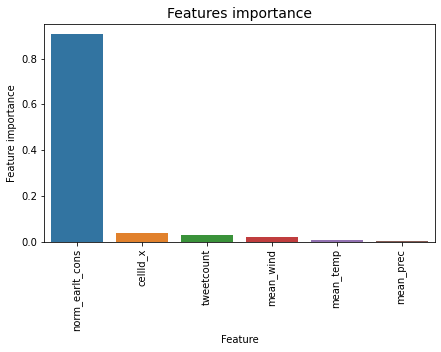

In [43]:
plot_feature_importance()

In [44]:
def plot_feature_importance_s():
    clf.fit(X_train_s, y_train_s)
    tmp = pd.DataFrame({'Feature': ['norm_late_cons','cellId_x', 'tweetcount', 'mean_prec', 'mean_wind', 'mean_temp'], 'Feature importance': clf.feature_importances_})
    tmp = tmp.sort_values(by='Feature importance',ascending=False)
    plt.figure(figsize = (7,4))
    plt.title('Features importance',fontsize=14)
    s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show()  

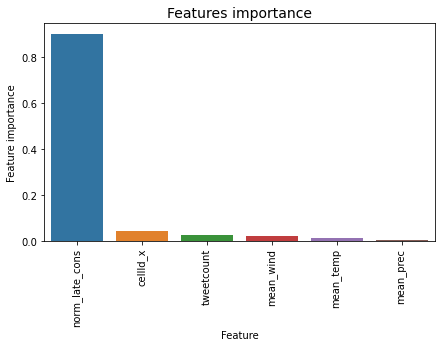

In [45]:
plot_feature_importance_s()

Si vede bene che il maggior contributo è dato dal valore di potenza. Giustifica anche il fatto di aver fatto un fillna con zeri.

**CROSS VALIDATION**

In [49]:
from sklearn.model_selection import cross_validate
from sklearn import linear_model

In [50]:
lasso = linear_model.Lasso()

In [51]:
results_m = cross_validate(lasso, X_train_m, y_train_m)
results_s = cross_validate(lasso, X_train_s, y_train_s)

In [52]:
results_m

{'fit_time': array([0.02188349, 0.01750517, 0.00759721, 0.01139688, 0.00879502]),
 'score_time': array([0.00496221, 0.00259829, 0.00375295, 0.00249338, 0.00247908]),
 'test_score': array([ 0.40386913,  0.61665186,  0.58262995,  0.37477672, -0.3387025 ])}

In [53]:
results_s

{'fit_time': array([0.00724959, 0.00706863, 0.0083189 , 0.00922275, 0.00916505]),
 'score_time': array([0.00259089, 0.00263643, 0.00243664, 0.00244236, 0.00246882]),
 'test_score': array([ 0.30482277,  0.62411452,  0.55383051,  0.43041544, -0.17622282])}

*Vado a considerare diversi classificatori*

In [54]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier

In [55]:
ridge = linear_model.RidgeClassifier(max_iter = 1000)
#clf = RandomForestClassifier(oob_score = True)
LRC = LogisticRegression(max_iter = 1000)
#neigh = KNeighborsClassifier()

*Li faccio allenare su i set di training*

In [56]:
#clf_m = clf.fit(X_train_m, y_train_m)
ridge_m = ridge.fit(X_train_m, y_train_m)
LRC_m = LRC.fit(X_train_m, y_train_m)
#neigh_m = neigh.fit(X_train_m, y_train_m)

*Faccio le mie predizioni*

In [57]:
#clf_pred_m = clf.predict(X_test_m)
ridge_pred_m = ridge.predict(X_test_m)
LRC_pred_m = LRC.predict(X_test_m)
#neigh_pred_m = neigh.predict(X_test_m)

*Valuto i miei classificatori*

In [58]:
from sklearn.metrics import confusion_matrix

#a = confusion_matrix(y_test_m, clf_pred_m)
aa = confusion_matrix(y_test_m, ridge_pred_m)
aaa = confusion_matrix(y_test_m, LRC_pred_m)
#aaaa = confusion_matrix(y_test_m, neigh_pred_m)

[ aa, aaa]

[array([[905,   0],
        [240, 124]]),
 array([[905,   0],
        [  5, 359]])]

Le classi sono evidentemente sbilanciate... i positivi sono sempre in numero preponderante --> è meglio usare la PREC-REC curve

In [59]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_m, ridge.decision_function(X_test_m))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.96


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.96')

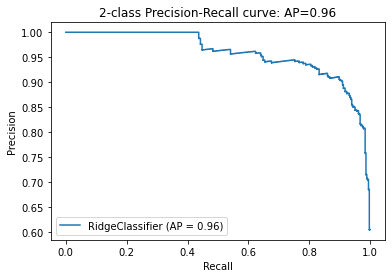

In [60]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(ridge, X_test_m, y_test_m)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

Ripetiamo la procedura per gli altri due classificatori

In [61]:
average_precision = average_precision_score(y_test_m, LRC.decision_function(X_test_m))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 1.00


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=1.00')

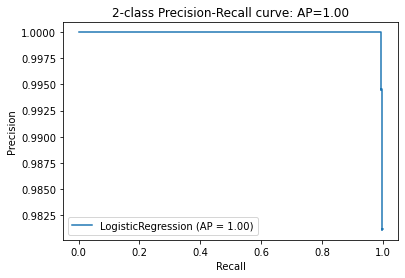

In [62]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(LRC, X_test_m, y_test_m)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

*Ripeto per i set di dati riferiti alla sera*

In [65]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier

In [66]:
ridge = linear_model.RidgeClassifier(max_iter = 1000)
#clf = RandomForestClassifier()
LRC = LogisticRegression(max_iter = 1000)
#neigh = KNeighborsClassifier()

In [67]:
#clf_s = clf.fit(X_train_s, y_train_s)
ridge_s = ridge.fit(X_train_s, y_train_s)
LRC_s = LRC.fit(X_train_s, y_train_s)
#neigh_s = neigh.fit(X_train_s, y_train_s)

In [68]:
#clf_pred_s = clf.predict(X_test_s)
ridge_pred_s = ridge.predict(X_test_s)
LRC_pred_s = LRC.predict(X_test_s)
#neigh_pred_s = neigh.predict(X_test_s)

In [69]:
from sklearn.metrics import confusion_matrix

#b = confusion_matrix(y_test_s, clf_pred_s)
bb = confusion_matrix(y_test_s, ridge_pred_s)
bbb = confusion_matrix(y_test_s, LRC_pred_s)
#bbbb = confusion_matrix(y_test_s, neigh_pred_s)

[bb, bbb]

[array([[1020,    0],
        [ 118,  131]]),
 array([[1020,    0],
        [ 130,  119]])]

In [70]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_s, ridge.decision_function(X_test_s))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.98


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.98')

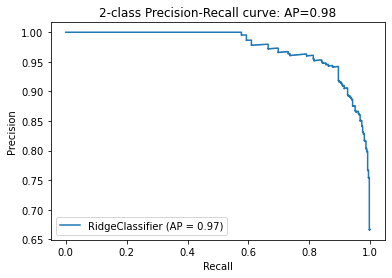

In [71]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(ridge, X_test_m, y_test_m)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [72]:
average_precision = average_precision_score(y_test_s, LRC.decision_function(X_test_s))

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 1.00


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=1.00')

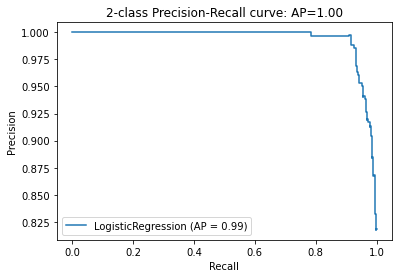

In [73]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(LRC, X_test_m, y_test_m)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

Per l'analisi fatta mi sembra inutile la cross validation (spero di non essermi perso niente).

**COMMENTI:**
La Logistic Regression ci dà un valore di precisione pari al 100%: questo perchè sta facendo il procedimento inverso rispetto a quello che abbiamo fatto noi, ovvero sta andando a trovare la treshold che noi abbiamo dato all'inizio.